In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [44]:
BACKGROUND_LABEL = 0
BORDER_LABEL = 1
CONTENT_LABEL = 2

# 图像编码处理
一张RGB彩色模型的图像可以看成一个三维矩阵，矩阵中的每一个数表示了图像上不同的位置，不同颜色的亮度。然而图像在存储时并不是直接记录这些矩阵中的数字，而是记录经过压缩编码之后的结果。所以要将一张图片还原成一个三维矩阵，需要解码过程。tensorflow提供了jpeg和png格式图像的编码/解码的函数。

The attr channels indicates the desired number of color channels for the decoded image.
- 0: Use the number of channels in the PNG-encoded image.
- 1: output a grayscale image.
- 3: output an RGB image.
- 4: output an RGBA image.

In [32]:
# 读取图像的原始数据
image_raw_data = tf.io.read_file(r"D:\studyhard_lin\2025_research\code_program\DeepPanel-master\dataset\test\segmentation_mask\sample_page_9.png")

In [33]:
# 对图像进行jpeg的格式解码从而得到图像对应的三维矩阵。tensorflow还提供了
# tf.image.decode_png 函数对png格式的图像进行解码。解码之后的结果为一个
# 张量，在使用它的取值之前需要明确调用运行的过程。
img_data = tf.io.decode_png(image_raw_data)
 
print(img_data.numpy())

[[[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 ...

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]]


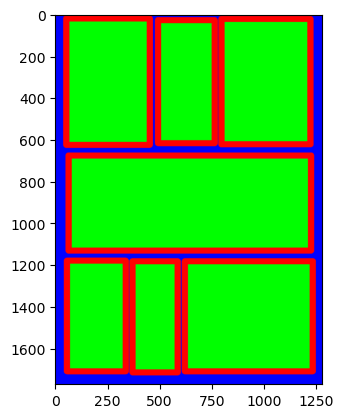

In [51]:
# 使用pyplot工具可视化得到的图像。
plt.imshow(img_data.numpy())
plt.show()

In [62]:
img = tf.io.decode_png(image_raw_data, channels=1) # 转换为灰度图 
print(img.numpy().shape)

(1771, 1280, 1)


In [67]:
unique_values = np.unique(img.numpy().reshape(1771, -1)) #降维为二维数组并统计唯一值

In [70]:
img.numpy().reshape(1771, -1)

array([[29, 29, 29, ..., 29, 29, 29],
       [29, 29, 29, ..., 29, 29, 29],
       [29, 29, 29, ..., 29, 29, 29],
       ...,
       [29, 29, 29, ..., 29, 29, 29],
       [29, 29, 29, ..., 29, 29, 29],
       [29, 29, 29, ..., 29, 29, 29]], dtype=uint8)

In [68]:
print(unique_values)

[ 29  76 149]


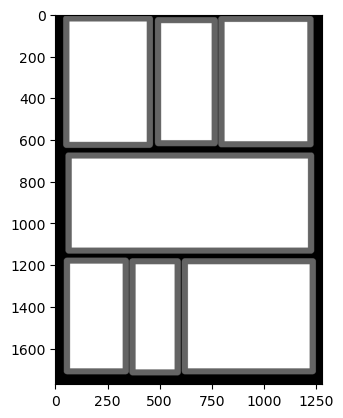

In [59]:
# 使用pyplot工具可视化得到的图像。
plt.imshow(img.numpy(), cmap='gray')
plt.show()

In [60]:
# Transform mask colors into labels
mask = img
# We will assume whites 0 which should be assigned to the background label
mask = tf.where(mask == 255, np.dtype('uint8').type(BACKGROUND_LABEL), mask)
# Dark values will use label the background label
mask = tf.where(mask == 29, np.dtype('uint8').type(BACKGROUND_LABEL), mask)
# Intermediate values will act as the border
mask = tf.where(mask == 76, np.dtype('uint8').type(BORDER_LABEL), mask)
mask = tf.where(mask == 134, np.dtype('uint8').type(BORDER_LABEL), mask)
# Brighter values will act as the content
mask = tf.where(mask == 149, np.dtype('uint8').type(CONTENT_LABEL), mask)

In [61]:
# 将表示一张图像的三维矩阵重新按照jpeg格式编码并存入文件中。打开这张图片，
# 可以得到和原始图像一样的图像。
encoded_image = tf.io.encode_jpeg(img_data)
tf.io.write_file("./output/image.jpg", encoded_image)

# 颜色空间转换

在TensorFlow中，将RGB图像转换为灰度图像时，通常使用`tf.image.rgb_to_grayscale`函数。灰度图像的取值范围是[0, 255]，其中0表示黑色，255表示白色。在TensorFlow中，图像数据通常以浮点数格式保存，其数值范围是[0.0, 1.0]，表示为四舍五入到最接近的整数。

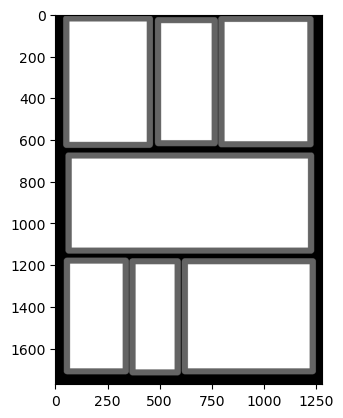

In [49]:
# 将RGB图像转换为灰度图
gray_image = tf.image.rgb_to_grayscale(img_data)

# 使用pyplot工具可视化得到的图像。
plt.imshow(gray_image.numpy(), cmap='gray')
plt.show()

# 图像标注框
在很多图像识别任务的数据集中，图像中需要关注的物体通常会用标注框圈起来。

Draw bounding boxes on a batch of images.
- Outputs a copy of `images` but draws on top of the pixels zero or more bounding boxes specified by the locations in `boxes`
- The coordinates of the each bounding box in boxes are encoded as [y_min, x_min, y_max, x_max]. The bounding box coordinates are floats in [0.0, 1.0] relative to the width and the height of the underlying image.
- images:A Tensor. Must be one of the following types: float32, half. 4-D with shape [batch, height, width, depth]. A batch of images.
- boxes: A Tensor of type float32. 3-D with shape [batch,num_bounding_boxes, 4] containing bounding boxes.
- colors: 	A Tensor of type float32. 2-D. A list of RGBA colors to cycle through for the boxes.
- Returns: A Tensor.

In [7]:
# create an empty image
img = tf.zeros([1, 3, 3, 3])
# draw a box around the image
box = np.array([0, 0, 1, 1])
boxes = box.reshape([1, 1, 4])
# alternate between red and blue
colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
tf.image.draw_bounding_boxes(img, boxes, colors)

<tf.Tensor: shape=(1, 3, 3, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]]], dtype=float32)>